In [43]:
# !git clone -b geral https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [44]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
torch.__version__

'2.0.0+cu118'

### Customiza parametros da rede neural profunda equivariante

In [45]:
def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 8
    args.margin_loss = 2.0
    args.border  = 3
    args.exported = False
    return args

### Prepara dataloader transformado (preprocessamento)
- cria script de preprocessamento
- cria dataset e data load
- recupera o primeiro lote de dados

In [46]:

args = custom_config(args)
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)

In [47]:
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

8 tensor([0, 0, 0, 0, 0, 0, 0, 0])


### Carrega modelo e realiza a predição
- carrega modelo treinado (deteccao e orientacao)
- realiza predição
- aplica data argumentation sobre os dados de entrada e saida
- realiza predicao sobre os dados transformados

In [48]:
from training import KeyEqGroup, KeyPointsSelection, remove_borders, random_augmentation, shifted_batch_tensor
from utils import load_model, imshow, imshow2, imshow3,NMSHead
MODEL_PATH = "./data/models/model_flowers_ssim.pt"

model = load_model_trained(args,device,path=MODEL_PATH)

Já foi treinado
epoca 100 loss 3.536601146062214


In [49]:
import kornia
from predict import compute_gradient_direction

torch.manual_seed(42)

angles =  torch.tensor([45,90,135,180,225,270,360], dtype=torch.float32).to(device)
print(angles)
#cria mascara para remocao de borda
_B, _C, _W, _H = img_batch.shape
SIZE_BORDER = args.border
batch_mask = torch.zeros(_B, 1, _W, _H).to(device)
batch_mask[:, :, SIZE_BORDER:_W - SIZE_BORDER, SIZE_BORDER:_H - SIZE_BORDER] = 1


def change_transform(batch_imgs,mask,angle):
    batch_imgs_trans = kornia.geometry.transform.rotate(batch_imgs, angle)
    mask_trans = kornia.geometry.transform.rotate(mask, angle)
    return batch_imgs_trans,mask_trans

def transform_predict(model,batch_imgs,mask,angle):
    model.eval()
    with torch.no_grad():
        if angle != None:
            batch_imgs_trans,mask_trans = change_transform(batch_imgs,mask,angle)
        else:
            batch_imgs_trans,mask_trans = batch_imgs,mask
        _kp, _orie = model(batch_imgs_trans)
        ori_arg_max1= compute_gradient_direction(_orie)
    return _kp*mask_trans, ori_arg_max1*mask_trans,

tensor([ 45.,  90., 135., 180., 225., 270., 360.], device='cuda:0')


In [50]:
_kp1, ori_arg_max1 = transform_predict(model,img_batch.to(device),batch_mask,None)
_kp1.shape, ori_arg_max1.shape

(torch.Size([8, 1, 180, 180]), torch.Size([8, 1, 180, 180]))

In [51]:
print(angles[0])
_kp2, ori_arg_max2 = transform_predict(model,img_batch.to(device),batch_mask,angles[0])
_kp2.shape,ori_arg_max2.shape

tensor(45., device='cuda:0')


(torch.Size([8, 1, 180, 180]), torch.Size([8, 1, 180, 180]))

### Visualizar o resultado dos mapas de ativações:
#### - magnitude
#### - orientação (max entre todos os filtros de grupo)

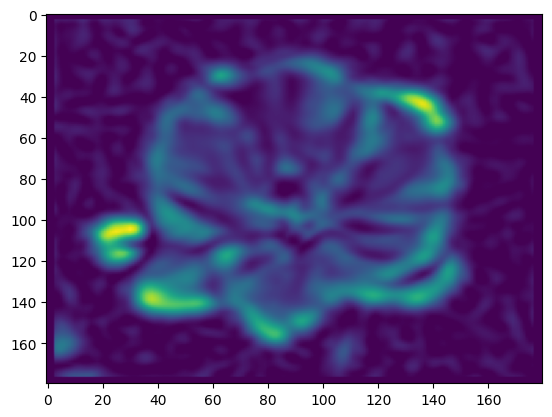

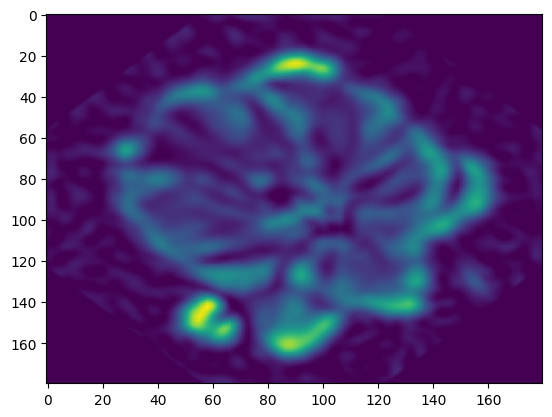

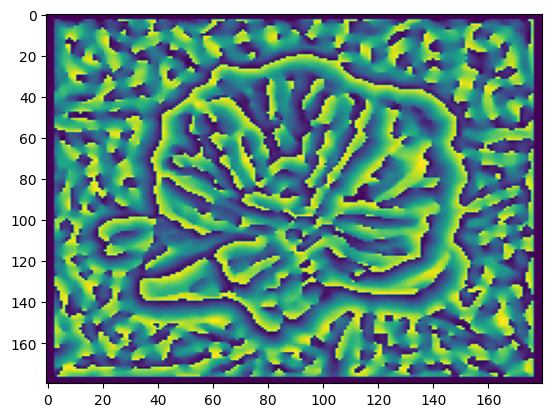

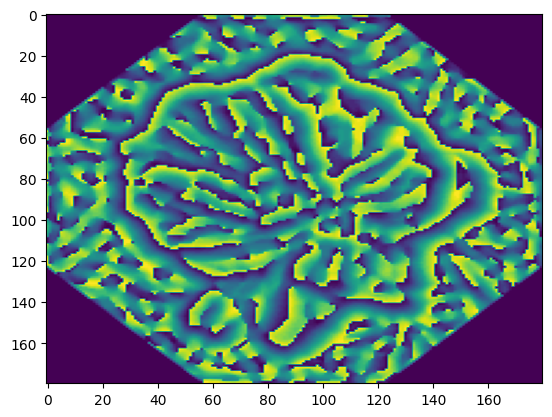

In [52]:
index = 5

plt.imshow(_kp1[index][0].cpu().detach(), aspect='auto')
plt.show()
plt.imshow(_kp2[index][0].cpu().detach(), aspect='auto')
plt.show()

plt.imshow(ori_arg_max1[index][0].cpu().detach(), aspect='auto')
plt.show()
plt.imshow(ori_arg_max2[index][0].cpu().detach(), aspect='auto')
plt.show()



### Computar um histograma que traz a magnitude x orientação

#### Somátorio da magnitude do gradiente no intervalo (bin) da direção
1. cria um filto (a) circular;
2. cria filtros (b) por intervalo da orientação sobre o mapa de ativação da orientação;
3. aplica a intercção entre os filtros (a) e (b) sobre o mapa de ativação da detecção;
4. realiza o somatorio dos itens filtrado e define como o valor do bin.
5. repete a partir do item 2 para cada bin do histograma.

180 180


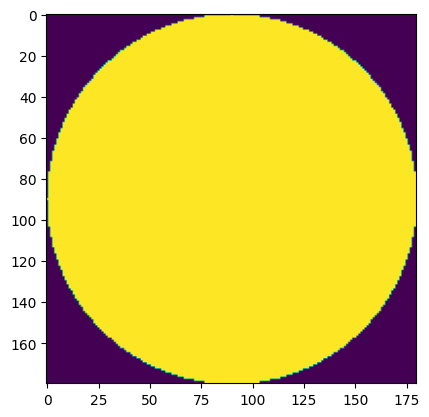

In [53]:
# filtro circular
from utils import create_circular_mask,create_circular_mask2,create_interval_mask,intersection_filter_interval_mask

circular_mask = create_circular_mask(_H,_W)
print(_H,_W)
plt.imshow(circular_mask)

((180, 180), (180, 180), numpy.ndarray, numpy.ndarray)

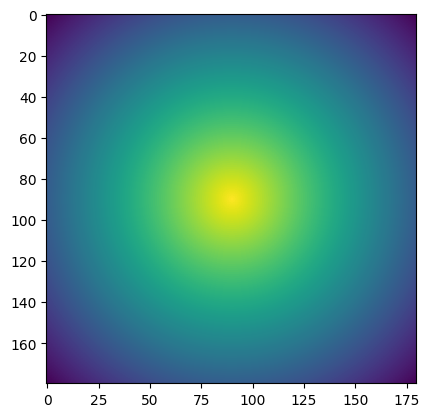

In [54]:
alternative_mask = create_circular_mask2(_H,_W)
plt.imshow(alternative_mask)
circular_mask.shape,alternative_mask.shape,type(circular_mask),type(alternative_mask)

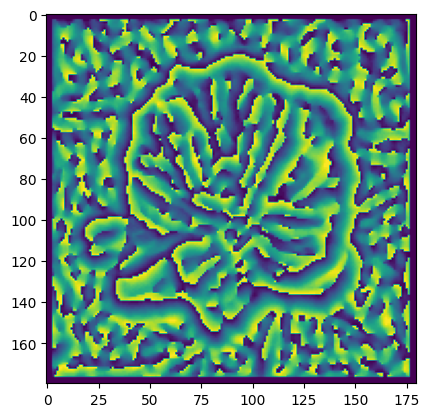

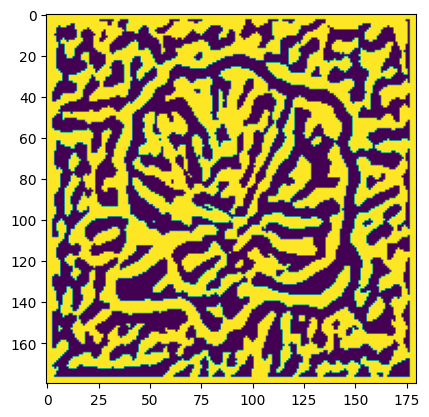

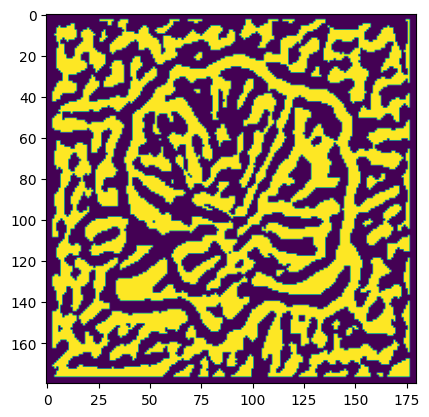

In [55]:
# filtros (b) por intervalo da orientação
plt.imshow(ori_arg_max1[index,0].cpu().detach())
plt.show()

interval_mask = create_interval_mask(ori_arg_max1,0,180)
plt.imshow(interval_mask[index,0].cpu().detach())
plt.show()

interval_mask2 = create_interval_mask(ori_arg_max1,180,360)
plt.imshow(interval_mask2[index,0].cpu().detach())
plt.show()

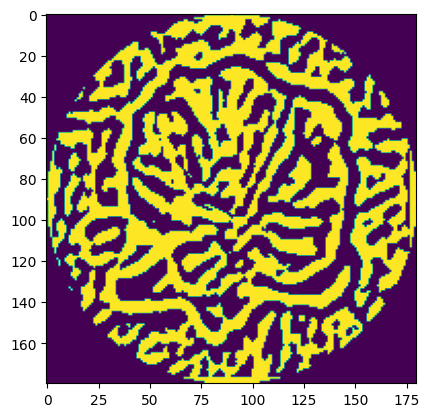

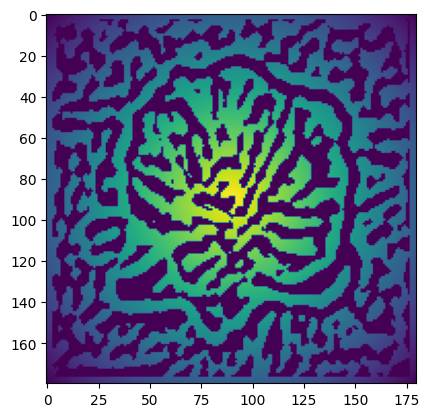

In [56]:
# aplicar intersecção entre os 2 filtros

mask_simples  = intersection_filter_interval_mask(interval_mask,torch.tensor(circular_mask[None]))
mask_alternative  = intersection_filter_interval_mask(interval_mask,torch.tensor(alternative_mask[None]))



plt.imshow(mask_simples[index,0].cpu().detach())
plt.show()


plt.imshow(mask_alternative[index,0].cpu().detach())
plt.show()

antes da multi torch.Size([8, 1, 180, 180]) torch.Size([8, 1, 180, 180])
depois  torch.Size([8, 1, 180, 180]) torch.Size([8, 1])


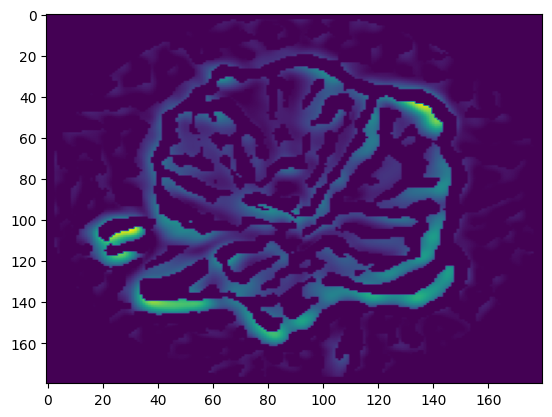

In [57]:
# computar somátorio entre os pixeis ativo pela filtragem
from utils import sum_filtered_intensity,build_histogram_orientation

print('antes da multi',_kp1.shape,mask_simples.shape)
sum_b, batch_filtered = sum_filtered_intensity(_kp1,mask_simples)
print('depois ',batch_filtered.shape,sum_b.shape)

plt.imshow(batch_filtered[index,0].cpu().detach(), aspect='auto')
plt.show()

#### Interar e construir um histograma com varios filtros de intervalo de bin

torch.Size([8, 1, 180, 180]) torch.Size([8, 1, 180, 180])


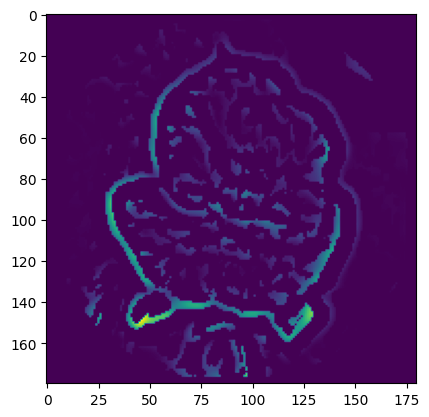

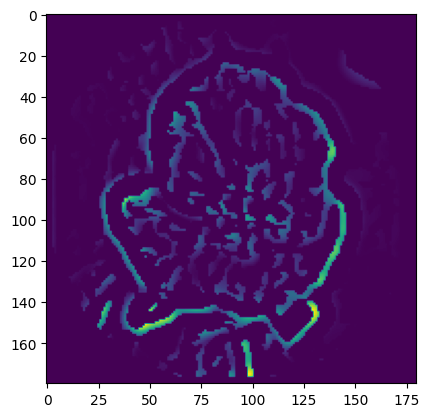

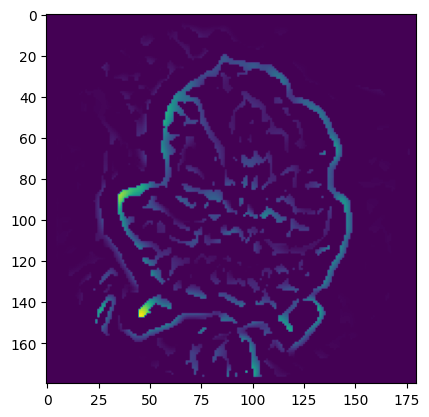

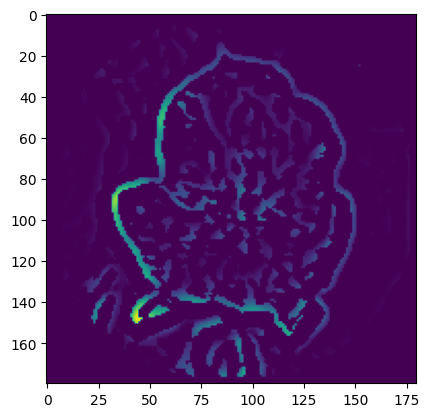

(torch.Size([8, 4]),
 tensor([[0.3434, 0.3415, 0.3495, 0.3525],
         [0.2074, 0.2048, 0.2090, 0.2237],
         [0.4241, 0.4337, 0.4284, 0.4218],
         [0.3618, 0.3461, 0.3491, 0.3484],
         [0.3964, 0.4045, 0.4055, 0.4236],
         [0.2279, 0.2149, 0.2171, 0.2186],
         [0.4406, 0.4499, 0.4400, 0.4142],
         [0.3536, 0.3482, 0.3515, 0.3571]], device='cuda:0'))

In [58]:
num_bin = 4
#Idealmente eu poderia passar um conjunto de features
#com a orientacao max e o seus mapas de ativacao e tamanho de bin
print(ori_arg_max1.shape,_kp1.shape)
hist1_b = build_histogram_orientation(ori_arg_max1,_kp1,circular_mask,num_bin,show=True)
hist1_b.shape,hist1_b

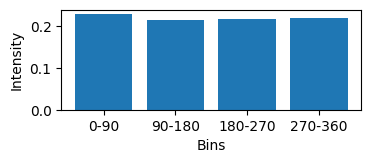

In [59]:
# funcao para exibir grafico de histograma com labels
def plot_histogram(hist):
    fig = plt.figure(figsize=(3,1))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(np.arange(len(hist)),hist)
    #colocar labels
    n_bin = len(hist)
    angle = 360/n_bin
    labels = ["{}-{}".format(int(i*angle),int((i+1)*angle)) for i in range(n_bin)]
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(labels)
    #titulo nos eixos
    ax.set_xlabel('Bins')
    ax.set_ylabel('Intensity')
    plt.show()


# def plot_histogram(hist):
#     fig = plt.figure(figsize=(3,1))
#     ax = fig.add_axes([0,0,1,1])
#     ax.bar(np.arange(len(hist)),hist)
#     plt.show()


plot_histogram(hist1_b[index].cpu().detach())

### Aplicar o shift dos bin do histograma de modo que o mesmo fique sempre numa mesma posição
- determinar a posição do bin de maior valor 
- realizar o movimento de shift numa determinada direção
- armazena os movimentos
- normaliza o histograma

In [60]:
# realiza shift no histograma de maneira controlada

In [61]:
# normaliza o histograma


### Commentarios
---
Em suma para realização da correspondencia de imagem utilizamos uma estratégia semelhante ao histograma orientado a gradiente aplicado a redes neurais profunda equivalirante a rotação, onde campo de atuação do histograma esta restrito a uma mascara circular.
Dentro da analise do histograma global temos ainda que o maior bin pode ajudar no alinhamento da imagem para encontramos um padrão.

### Testando os matching entre as caracteristicas

- Ja calculamos os histogramas das caracteristicas originais acima
- Calcularemos os histogramas as caracteristicas transformadas
- Nesse exemplo cada imagem representa uma caracteristica, porém no algoritmo final será uma sub-imagem
- Todos os histogramas serão normalizados entre o batch
- compararemos os histogramas original com os transformados para encontrar a correspondencia

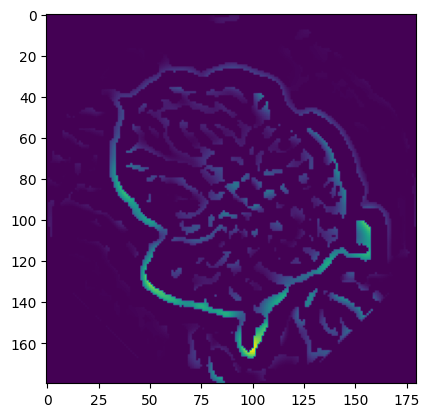

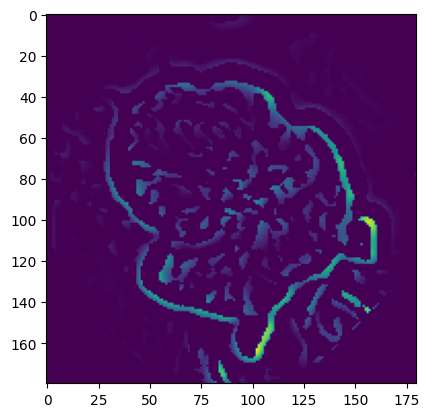

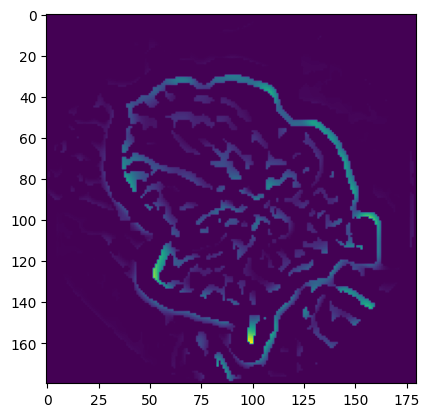

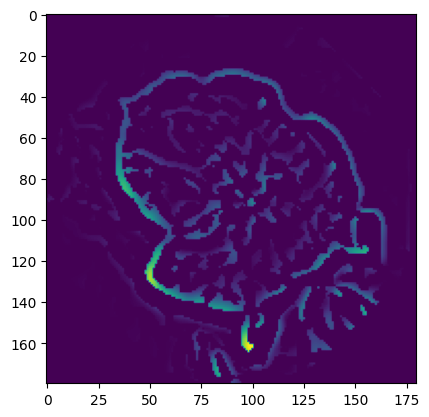

tensor([[0.3512, 0.3313, 0.3465, 0.3557],
        [0.2115, 0.2095, 0.2109, 0.2155],
        [0.4280, 0.4304, 0.4343, 0.4168],
        [0.3492, 0.3524, 0.3456, 0.3601],
        [0.4149, 0.3993, 0.4038, 0.4099],
        [0.2241, 0.2262, 0.2024, 0.2196],
        [0.4159, 0.4525, 0.4433, 0.4322],
        [0.3625, 0.3486, 0.3561, 0.3473]], device='cuda:0')

In [62]:
hist2_b = build_histogram_orientation(ori_arg_max2,_kp2,circular_mask,num_bin,show=True)
hist2_b

In [63]:
def plot_histogram(hist,ax):
    ax.bar(np.arange(len(hist)),hist)
    #colocar labels
    n_bin = len(hist)
    angle = 360/n_bin
    labels = ["{}-{}".format(int(i*angle),int((i+1)*angle)) for i in range(n_bin)]
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(labels)
    #titulo nos eixos
    ax.set_xlabel('Bins')
    ax.set_ylabel('Intensity')


#exibe duas imagens lado a lado com matplotlib com dois titulos
def imshow_features_hist(img1,img2,hist=None,index="0",figsize=(14,3)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(img1,aspect='auto')
    ax1.title.set_text('feat i:'+index)
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(img2,aspect='auto')
    ax2.title.set_text('orie i:'+index)
    if hist is not None:
        ax3 = fig.add_subplot(1,3,3)
        plot_histogram(hist,ax3)
    plt.show()

In [64]:
import numpy as np

array1 = np.array([0, 1, 2, 3, 4, 5, 6, 7])
array2 = np.array([3, 1, 6, 0, 4, 5, 2, 7])

count = np.count_nonzero(np.equal(array1, array2))

print("Quantidade de elementos comuns:", count)


Quantidade de elementos comuns: 4


In [65]:
import torch
import numpy as np
from fastdtw import fastdtw
from scipy.optimize import linear_sum_assignment

def batch_histogram_distance(batch1, batch2):
    batch1 =batch1.cpu()
    batch2 =batch2.cpu()
    if batch1.size()[0] != batch2.size()[0]:
        raise ValueError("Os batches devem ter o mesmo tamanho.")

    batch_size = batch1.size()[0]
    n_bins = batch1.size()[1]

    distances = torch.zeros(batch_size, batch_size)

    for i in range(batch_size):
        for j in range(batch_size):
            hist1 = batch1[i].numpy().astype(float)
            hist2 = batch2[j].numpy().astype(float)
            distance, _ = fastdtw(hist1, hist2)
            distances[i, j] = distance

    row_ind, col_ind = linear_sum_assignment(distances.numpy())
    total_distance = distances[row_ind, col_ind]

    return total_distance, row_ind, col_ind

def batch_histogram_distance(batch1, batch2):
    batch1 =batch1.cpu()
    batch2 =batch2.cpu()
    if batch1.size()[0] != batch2.size()[0]:
        raise ValueError("Os batches devem ter o mesmo tamanho.")

    batch_size = batch1.size()[0]
    n_bins = batch1.size()[1]

    distances = torch.zeros(batch_size, batch_size)

    for i in range(batch_size):
        for j in range(batch_size):
            hist1 = batch1[i].numpy().astype(float)
            hist2 = batch2[j].numpy().astype(float)
            distance = np.sum(np.abs(hist1 - hist2))  # Cálculo da distância de Manhattan
            distances[i, j] = distance

    row_ind, col_ind = linear_sum_assignment(distances.numpy())
    total_distance = distances[row_ind, col_ind]
    print("Distância total entre os batches de histogramas:", total_distance)
    return total_distance, row_ind, col_ind

# Exemplo de batches de histogramas como tensores
batch1 = torch.tensor([[10, 20, 30, 40],
                       [ 80, 50, 60, 70],
                       [90, 100, 110, 120]])

batch2 = torch.tensor([[40, 60, 80, 20],
                       [60, 80, 20, 40],
                       [112, 118,85, 97]])

distance, row_ind, col_ind = batch_histogram_distance(batch1, batch2)
print("Distância total entre os batches de histogramas:", distance)

print("Correspondência entre os histogramas:")
for i in range(len(row_ind)):
    print(f"Histograma {i} do batch1 corresponde ao histograma {col_ind[i]} do batch2")


Distância total entre os batches de histogramas: tensor([120., 120.,  88.])
Distância total entre os batches de histogramas: tensor([120., 120.,  88.])
Correspondência entre os histogramas:
Histograma 0 do batch1 corresponde ao histograma 1 do batch2
Histograma 1 do batch1 corresponde ao histograma 0 do batch2
Histograma 2 do batch1 corresponde ao histograma 2 do batch2


In [68]:
def find_images(model,img_batch,batch_mask, angles):
    n_bin = 10
    index = 0
    is_show = False  
    size = len(img_batch)
    matches = []

    _B, _C, _W, _H = img_batch.shape
    SIZE_BORDER = args.border
    batch_mask = torch.zeros(_B, 1, _W, _H).to(device)
    batch_mask[:, :, SIZE_BORDER:_W - SIZE_BORDER, SIZE_BORDER:_H - SIZE_BORDER] = 1
    total_dist = 0
    total_acertos = 0
    for (img_batch, labels) in testloader:
        img_batch = img_batch.to(device)
        _kp1, ori_arg_max1 = transform_predict(model,img_batch,batch_mask,None)
        hist1_b = build_histogram_orientation(ori_arg_max1,_kp1,alternative_mask,n_bin=n_bin,show=False)

        if is_show:
            imshow_features_hist(_kp1[index,0].cpu().detach(),ori_arg_max1[index,0].cpu().detach(),hist1_b[index].cpu().detach(),index=str(0))
        for angle in angles:
        
            _kp2, ori_arg_max2 = transform_predict(model,img_batch,batch_mask,angle)
            hist2_b = build_histogram_orientation(ori_arg_max2,_kp2,alternative_mask,n_bin=n_bin,show=False)
            dist,row_i,col_i = batch_histogram_distance(hist1_b,hist2_b)
            acertos = np.count_nonzero(np.equal(row_i, col_i))

            total_dist += dist.sum()
            total_acertos += acertos
            print("avalia correspondencia para o angulo {} graus distac total {} acertos {} ".format(angle.item(),dist.sum(),acertos))
            if is_show:
                imshow_features_hist(_kp2[index,0].cpu().detach(),ori_arg_max2[index,0].cpu().detach(),hist2_b[index].cpu().detach(),index=str(angle))
    return total_dist,total_acertos

# find_images(model,img_batch,batch_mask,angles)
total_dist,total_acertos = find_images(model,img_batch.to(device),batch_mask,angles)
total_dist,total_acertos

Distância total entre os batches de histogramas: tensor([0.0867, 0.1173, 0.1136, 0.0902, 0.1121, 0.0904, 0.1388, 0.1002])
avalia correspondencia para o angulo 45.0 graus distac total 0.8492680788040161 acertos 8 
Distância total entre os batches de histogramas: tensor([0.1443, 0.0902, 0.1732, 0.0833, 0.1330, 0.1373, 0.1764, 0.0597])
avalia correspondencia para o angulo 90.0 graus distac total 0.9974656701087952 acertos 6 
Distância total entre os batches de histogramas: tensor([0.1972, 0.0904, 0.1646, 0.0958, 0.2002, 0.1872, 0.2467, 0.0626])
avalia correspondencia para o angulo 135.0 graus distac total 1.2446763515472412 acertos 6 
Distância total entre os batches de histogramas: tensor([0.2059, 0.1077, 0.1373, 0.0741, 0.1426, 0.0966, 0.2000, 0.0720])
avalia correspondencia para o angulo 180.0 graus distac total 1.0360748767852783 acertos 6 
Distância total entre os batches de histogramas: tensor([0.1983, 0.1011, 0.1139, 0.0853, 0.1848, 0.1435, 0.2213, 0.0709])
avalia correspondencia p

RuntimeError: The size of tensor a (5) must match the size of tensor b (8) at non-singleton dimension 0

### Teste com copilot

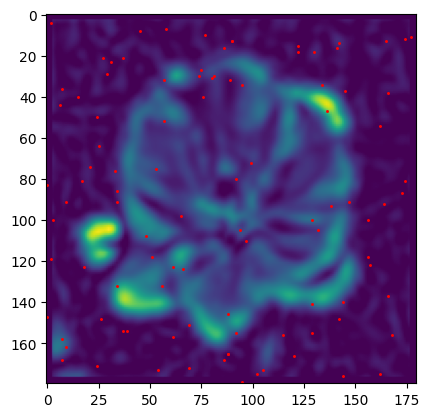

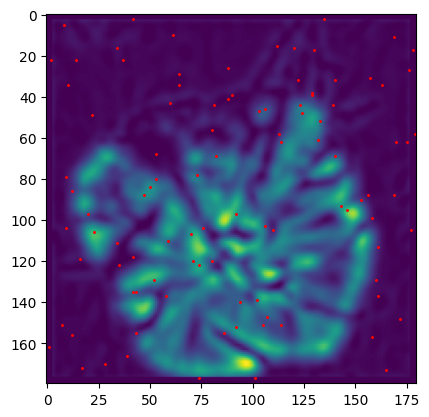

(100, 100)
torch.return_types.min(
values=tensor([ 8.0623,  5.0000, 15.5242,  6.3246,  7.0711,  9.0000,  6.0828,  5.0990,
         1.0000, 13.1529,  6.0828,  8.9443,  6.0828, 15.2971,  5.6569,  8.4853,
         7.8102,  3.6056,  5.8310, 10.7703,  2.2361,  9.4868, 21.2132,  4.4721,
         2.2361,  5.0000,  3.0000,  2.8284,  3.6056,  7.2801, 17.2627, 13.0000,
        13.3417, 10.4403, 14.8661,  6.4031,  4.1231, 15.6525, 10.2956,  2.2361,
        11.1803, 12.3693,  9.4340, 18.1108,  6.0828, 10.1980,  7.0711, 11.3137,
         7.2111,  5.0000, 11.0454, 16.0000, 16.5529, 10.0499,  8.6023,  5.0000,
         8.0623,  4.2426,  7.2111,  6.0828,  8.2462,  6.7082,  5.3852, 11.4018,
         4.4721,  5.0990, 16.1245, 11.1803,  7.0711, 17.4642,  7.0711, 13.0000,
         4.1231, 10.1980, 13.1529, 13.1529,  1.0000,  6.4031, 18.3576,  8.6023,
        16.1555, 18.0278,  7.0711, 16.2788,  9.8489,  6.4031,  2.2361,  6.3246,
        17.2627, 18.4391,  7.6158, 14.0000,  4.2426, 10.1980, 10.6301,  4.1231

In [ ]:
def plot_image_with_keypoints(img,coordinates):
    plt.imshow(img)
    plt.scatter(coordinates[:, 1], coordinates[:, 0], s=5, marker='.', c='r')
    plt.show()

#gerar coordenadas aleatorias e exibir na tela
def generate_random_coordinates(img):
    coordinates = np.random.randint(0, img.shape[0], size=(100, 2))
    return coordinates

pt2 = generate_random_coordinates(_kp1[index][0].cpu().detach())
plot_image_with_keypoints(_kp1[index][0].cpu().detach(),pt2)
pt3 = generate_random_coordinates(_kp1[index][0].cpu().detach())
plot_image_with_keypoints(_kp1[index+1][0].cpu().detach(),pt3)

# calcular correspondencia entre os pontos de interesse pt2 e pt3 sua vizinhaça
def compute_correspondence(pt2,pt3):
    from scipy.spatial import distance_matrix
    dist = distance_matrix(pt2,pt3)
    return dist

dist = compute_correspondence(pt2,pt3)
print(dist.shape)
# mapear os index de correspondencia entre pt2 e pt3 com base na distancia
def map_correspondence(dist):
    dist = torch.tensor(dist)
    min_dist = torch.min(dist,1)
    return min_dist

min_dist = map_correspondence(dist)
print(min_dist)

